In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


fname = 'plummer_equilibrium_out.txt'

N = 10000
M_tot = 1
b = 1

The analysis was run using the following command line:

./treecode in=../../Plummer/plummer_equilibrium_initial.txt out=../../Plummer/plummer_equilibrium_out.txt dtime=0.1 eps=0.01 theta=0.1 tstop=60 dtout=0.1 > ../../Plummer/system_infos.txt


# Fetch the data from the output file

In [26]:
data = pd.read_csv(fname, header=None).to_numpy()

In [27]:
# take only the paired components every 3N+3 rows
# index 2: times
#index i: masses
# index i + N : positions
#index i + 2N : velocities

times = data[2::(3 * N + 3)].astype(float)

m = {}

for i in range(3, N + 3): # start from index==3 because we care about m_s, x_s and v_s 
    
    m[f"{i}_ms"]= data[i::(3 * N + 3)]
    m[f"{i}_xs"]= data[(i + N)::(3 * N + 3)]
    m[f"{i}_vs"]= data[(i + 2 * N)::(3 * N + 3)] 

In [28]:
m_data = {} # define a dictionary to order variables

for j in range(3, N + 3):

    m_data[f"{j - 3}_ms"] = np.array([m[f"{j}_ms"][i][0].split() for i in range(0, len(m[f"{j}_ms"]))]).astype(float)
    m_data[f"{j - 3}_xs"] = np.array([m[f"{j}_xs"][i][0].split() for i in range(0, len(m[f"{j}_xs"]))]).astype(float)
    m_data[f"{j - 3}_vs"] = np.array([m[f"{j}_vs"][i][0].split() for i in range(0, len(m[f"{j}_vs"]))]).astype(float)
        


In [29]:
times_plot = np.hstack(times) # create array from the previous times

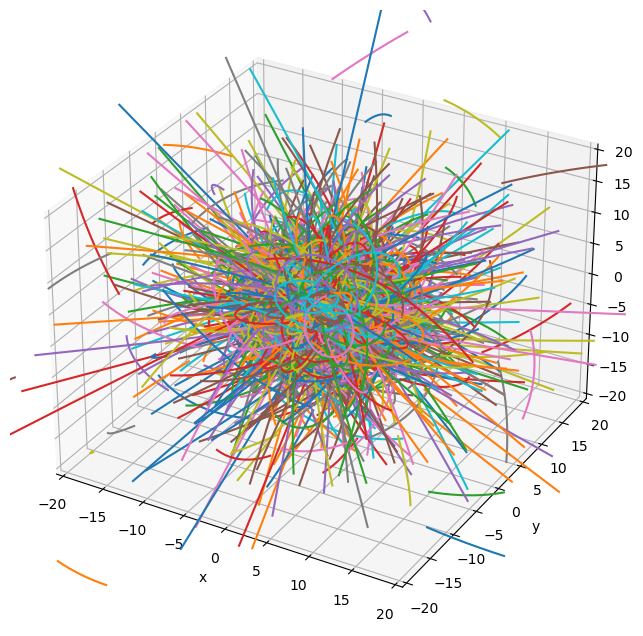

In [30]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,8))

for i in range(0, N):

    ax.plot(m_data[f"{i}_xs"][:, 0], m_data[f"{i}_xs"][:, 1], m_data[f"{i}_xs"][:, 2], label=f"{i}th particle", linestyle='-')

    
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)

plt.show()


![Cat GIF](plummer_sphere_10000_bodies.gif)

## Piece of code in ordere to generate the animation

In [31]:
my_x = np.zeros((N, len(times)))
my_y = np.zeros((N, len(times)))
my_z = np.zeros((N, len(times)))

for i in range(0,N):
    for j in range(0,len(times)):
        my_x[i,j] = m_data[f"{i}_xs"][j][0]
        my_y[i,j] = m_data[f"{i}_xs"][j][1]
        my_z[i,j] = m_data[f"{i}_xs"][j][2]
    

  0%|          | 0/601 [00:00<?, ?it/s]

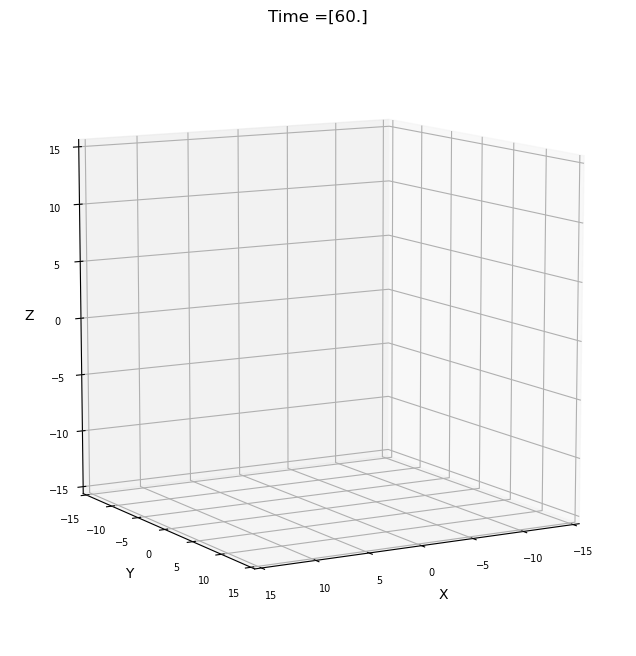

In [65]:
from tqdm.notebook import tqdm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

#plot------------------------------------------------------------------------------

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(projection='3d')
ax.set_aspect('equal')

ax.view_init(elev=10, azim=60)
ax.set_xlim(-15,+15)
ax.set_ylim(-15,+15)
ax.set_zlim(-15,+15)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='z', labelsize=7)


#animation--------------------------------------------------------------------------------
scatters, = ax.plot([], [], [], 'o', markersize='0.8', alpha=0.3)


def init():
    scatters.set_data([], [])
    scatters.set_3d_properties([])
    return scatters,

def animate_time(i): 
    scatters.set_data(my_x[:,i], my_y[:,i])
    scatters.set_3d_properties(my_z[:,i])
    ax.set_title('Time =' + str(np.round((np.array(times))[i])))
        
    return scatters,


num_frames = len(times)
animazione = FuncAnimation(fig, animate_time, frames=tqdm(range(len(times))), interval=100, init_func=init) #frames = num_frames interval =100

theta_ = np.linspace(0,2*np.pi,1000)

writergif = animation.PillowWriter(fps=10)
#writer = animation.PillowWriter(fps=30)
#animazione.save('plummer_sphere.gif', writer = 'ffmpeg', dpi=30)
animazione.save(f'plummer_sphere_{N}_bodies.gif', writer = writergif)
#plt.show()

plt.rcParams['animation.html'] = 'html5'
#animazione

### Building up our radii array

In [33]:
r_t = {}  # set an array where to store rays at different ts

for i in range(0, N):  
    
    r_t[f"{i}"] = np.sqrt(m_data[f"{i}_xs"][:, 0]**2 + m_data[f"{i}_xs"][:, 1]**2 + m_data[f"{i}_xs"][:, 2]**2)

In [34]:
rays_init = np.zeros(N)
for i in range(0,N):
    rays_init[i] = r_t[f"{i}"][0]

r_min = np.min(rays_init)

Here we printed the minimum value of the radii in order to have a starting point in order to compute the density profile of our system.

In [35]:
print(f"Min of the radii = {r_min}")

Min of the radii = 0.024193170704721594


In the code below we wanted to plot the profile density of our system, and compare it with the analytical solution: 

$$
    \rho (r) = \frac{3 M_{TOT}}{4 \pi b^3} \frac{1}{( 1 + \frac{r^2}{b^2})^{\frac{5}{2}}}
$$

In order to do this we computed the density of a set of shells of width $\text{dR}$ by counting how many particles were contained in the shell. But  I don't know how significative is this plot.

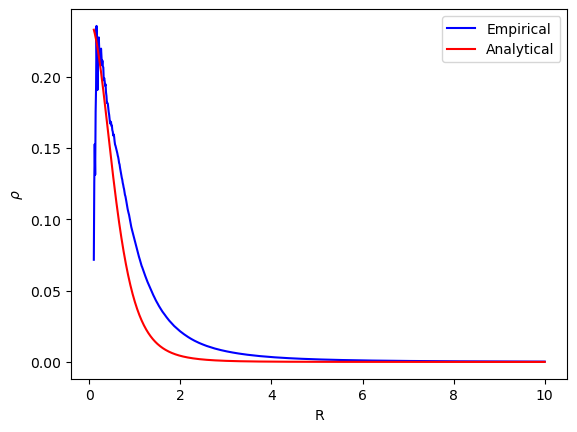

In [69]:
R_s = np.linspace(0.1, 10, 1000)
rho = np.zeros(len(R_s))
rho_analytical = np.zeros(len(R_s))
r_minimum = 0

for i in range(0, len(R_s)):
    M = 0
    for j in range(0,N):
        if r_t[f"{j}"][0] <= R_s[i] and r_t[f"{j}"][0] >= r_minimum:
            M += 0.0001
    
    rho[i] = M / (4/3 * np.pi * (R_s[i]**3 - r_minimum**3))
    # rho[i]  = M / (4/3 * np.pi * (R_s[i]**3))
    rho_analytical[i] = (3  /  (4 * np.pi)) / (1 + R_s[i]**2)**(5/2)
    r_minimummum = R_s[i]
    
    
plt.plot(R_s, rho, color="blue",label="Empirical")
plt.plot(R_s, rho_analytical, color="red", label="Analytical")
plt.xlabel("R")
plt.ylabel(r'$\rho$')
plt.legend()
    

We can notice that in the central region the two solution don't match, while moving to more external region the two curves can be well overlapped.
Let's try to plot the difference of the two curves in function of the radii.

Text(0, 0.5, '$\\mathrm{|\\rho_{emp} - \\rho_{an}|}$')

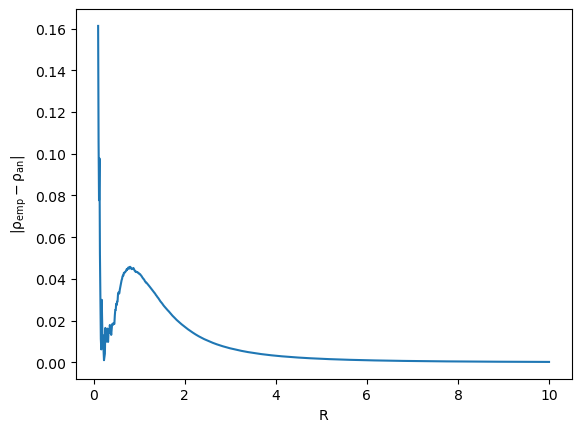

In [72]:
plt.plot(R_s, abs(rho_analytical-rho))
plt.xlabel("R")
plt.ylabel(r"$\mathrm{|\rho_{emp} - \rho_{an}|}$")


## Plot of the radii over time

In [38]:
r_t = {}  # set an array where to store rays at different ts

for i in range(0, N):  
    
    r_t[f"{i}"] = np.sqrt(m_data[f"{i}_xs"][:, 0]**2 + m_data[f"{i}_xs"][:, 1]**2 + m_data[f"{i}_xs"][:, 2]**2)

In the piece of code below we tried to plot the radii for all the particles. Since we have a lot of particles (10000), this plot is a bit confused, it's just to have a rough idea of what happens to our particles.

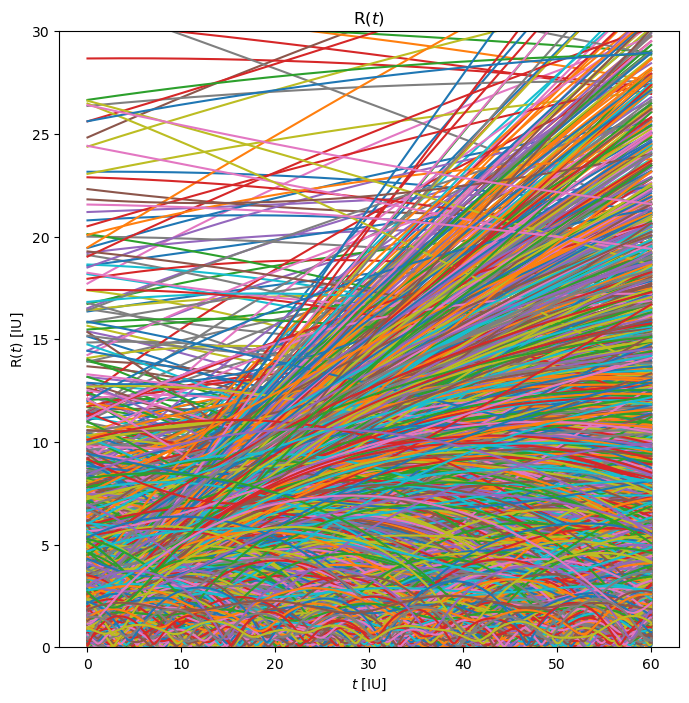

In [106]:
plt.figure(figsize = (8,8))

for i in range(0, N-1):

    plt.plot(times_plot, r_t[f"{i}"][:], label = f"{i} mass")

plt.xlabel("$t$ [IU]")
plt.ylabel("$\mathrm{R}(t)$ [IU]")
plt.title("$\mathrm{R}(t)$")
plt.ylim(0, 30)
plt.show()

# Energy analysis

As we want to prove that the system is at the equilibrium, we can show it by computing the total energy of the system, defined as:

$$
    E(t) = K(t) + U(t)
$$

where K is the kinetic energy of the system and U is its potential energy.

For a system at the equilibrium we expect that the total energy of the system will be conserved.
The value of the energy of the system at each time are taken by the file "system_infos.txt" generated by the tree code. In the code below we simply fetch the data of our interest from the file (basically T and U).

In [108]:
from scipy import linalg

In [109]:
en_file_name = "system_infos.txt"

In [110]:
en_data = pd.read_csv(en_file_name, header=None).to_numpy()
datas = pd.read_csv(en_file_name, header=None)


In order to extract the energies in a convenient way, we had to remove some lines from the dataset made using the data in the log file. 

In [111]:
raws_to_remove = []

for i in range(7,len(datas), 5):
    raws_to_remove.append(i)
    
raws_indexes = np.array(raws_to_remove)

good_data = datas.drop(raws_indexes)

data_good = good_data.to_numpy()



Now we plot the potential energy, kinetic energy and the total energy. We can see that the total energy is negative, therefore we still have a bound system.

In [114]:
times_energy = []
kinetic = []
potential = []

for i in range (6, len(good_data), 4):
    times_energy.append(float(data_good[i][0][6:12]))
    kinetic.append(float(data_good[i][0][21:28]))
    potential.append(float(data_good[i][0][30:36]))
                    

en_times = np.array(times_energy)
T = np.array(kinetic)
U = np.array(potential)
E_tot = T - U

E_med = np.average(E_tot)
E_stdev = np.std(E_tot)
                      

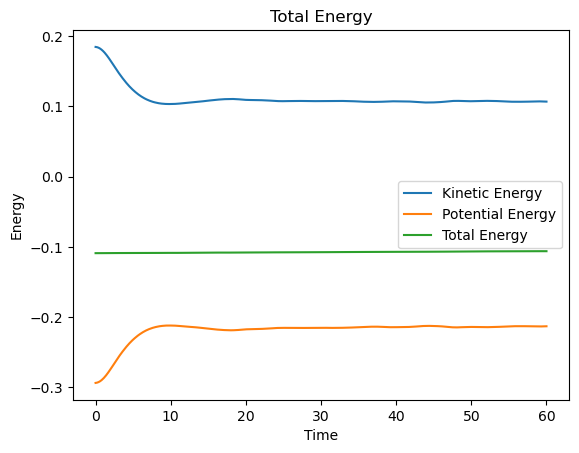

In [115]:
plt.plot(en_times, T, label="Kinetic Energy")
plt.plot(en_times, -U, label="Potential Energy")
plt.plot(en_times, E_tot, label="Total Energy")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Total Energy")
plt.legend()

Let's now zoom on the total energy, just to have a feedback about the total energy conservation.

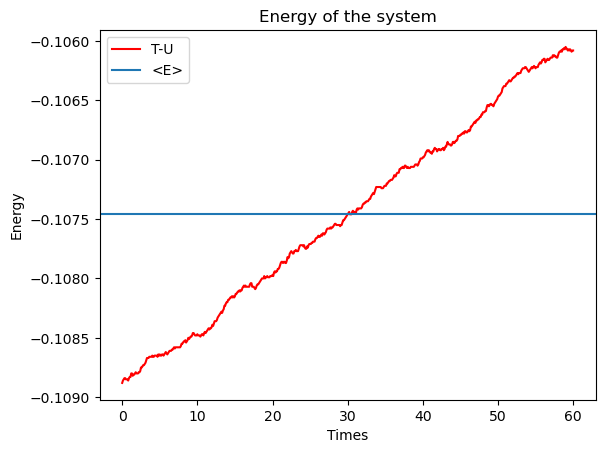

In [116]:
plt.figure()
#plt.plot(en_times, T, color='green', label='T')
#plt.plot(en_times, -U, color='blue', label='-U')
plt.plot(en_times, T-U, color='red', label='T-U')
plt.axhline(xmin=times[0], xmax=times[-1], y=E_med, label="<E>")
plt.xlabel("Times")
plt.ylabel("Energy")
plt.title("Energy of the system")
plt.legend()

We can see that the total energy of the system is not completely conserved (why?), but it increases with time. We don't know what can be the source of this increase of the energy, maybe there's something wrong in our settings. Let's try to have an estimate of the relative error with respect to the mean value of the energy, in order to check if the increase is significant or if it can be related to some integration bugs of the code. 

In [117]:
Rel_err_perc = abs(E_stdev / E_med * 100)

print(f"The relative error is {Rel_err_perc} %")

The relative error is 0.7817667947337315 %


# Virial analysis

In mechanics, the virial theorem provides a general equation that relates the average over time of the total kinetic energy of a stable system of discrete particles, bound by potential forces (forces characterized exclusively by potential difference), with that of the total potential energy of the system.

Let's now compute the virial ratio, the ratio of the total kinetic energy to the total potential energy. At the equilibrium, the virial ratio should approach $-0.5$.

In [119]:
virial_ratios = -T/U

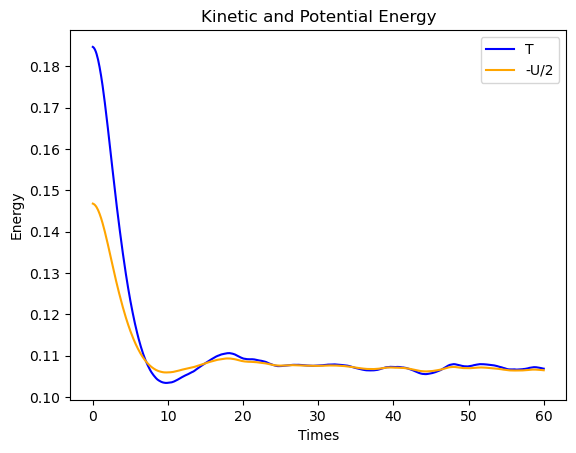

In [125]:
plt.plot(times, T, color='blue', label='T')
plt.plot(times, U/2, color='orange', label='-U/2')
plt.xlabel("Times")
plt.ylabel("Energy")
plt.title("Kinetic and Potential Energy")
plt.legend()

Computing the relaxation time and the dynamical time of the system (in IU): the relaxation seems to be twice the time of our integration.

In [129]:
# Compute the relaxation time, for which we need the half mass radius of the system.

r_h = 1.3 * b    
# Found on a paper
# "SN-driven mechanism of cusp-core transformation: an appraisal Jan D. Burger 1 and Jes ́us Zavala 1"

t_rel = 0.138 * (N / (np.log(0.4 * N))) * r_h**1.5 / (M/N)**0.5 
t_rel = (b**3 / M_tot)**0.5 * N / (8*np.log(N))
#t_rel = 0.1 * N * b / (np.log(N) * v)

t_dyn = np.sqrt((3 * np.pi) / (32 * rho[0]))

print(f"Dynamical time = {t_dyn}")
print(f"Relaxation time ={t_rel}")


Dynamical time = 2.027889337986806
Relaxation time =135.71702559476617


We now plot the values of the virial ratio during the whole time of our simulation. We can see that, after a certain amount of time.

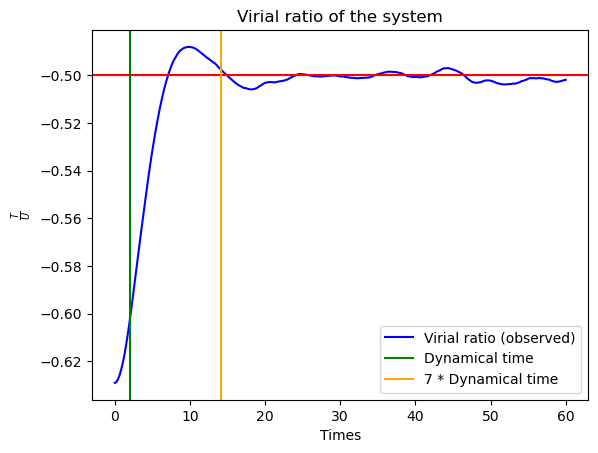

In [135]:
plt.figure()
#plt.plot(en_times, T, color='green', label='T')
#plt.plot(en_times, -U, color='blue', label='-U')
plt.plot(en_times, virial_ratios, color='blue', label='Virial ratio (observed)')
plt.axhline(xmin=en_times[0], xmax=en_times[-1], y=-0.5, color='r')
plt.axvline(x=t_dyn, color='green', label="Dynamical time")
plt.axvline(x=7.*t_dyn, color='orange', label="7 * Dynamical time")


plt.xlabel("Times")
plt.ylabel(r'$\frac{T}{U}$')
plt.title("Virial ratio of the system")
plt.legend()

We can see that at the beginning the virial ratio is quite different from $\text{0.5}$, while, after an amount of dynamical times (7 in our case), it approaches this value and starts to oscillate around it.

# Velocity distribution

We can also analyze the velocity distribution of particles in the simulation. At the equilibrium, the velocity distribution should resamble a Maxwellian distribution. 
Let's try to compute the velocity distribution at a time in which the virial ratio is equal to $-0.5$

In [136]:
indexes_vr = []
for i in range(0, len(virial_ratios)):
    if virial_ratios[i] == -0.5:
        indexes_vr.append(i)

indexes_vr

[290, 291]

In the code below we tried to make an histogram with the velocity distribution at a given time (in particular at a time at which the virial ratio is $-0.5$ in order to check the distribution can be described with a Maxwell distribution.

We first computed the square module of the velocities and we computed $<v^2>$. So, we computed $k_B T$ as:

$$
   \frac{3}{2}N k_B T = \frac{1}{2} <v^2>  \Longrightarrow k_B T = \frac{1}{3} <v^2> \frac{1}{N}
$$

And so we plotted the velocities distribution in order to see if it is comparable with:

$$
    f(v) = \Big( \frac{M}{2 N \pi k_B T}\Big)^{\frac{3}{2}} 4 \pi v^2 \exp{\Big(- \frac{M v^2}{2 N k_B T}\Big)}
$$

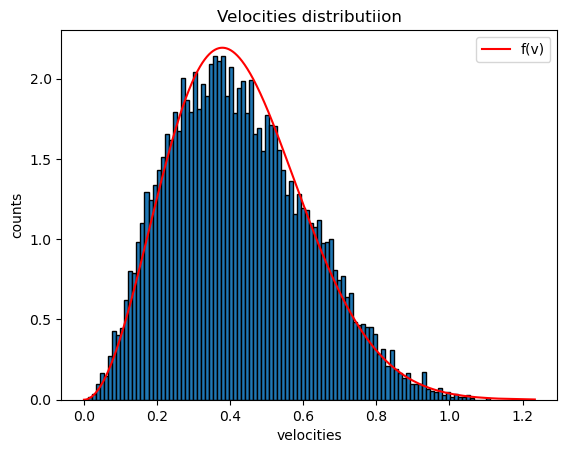

In [138]:
from scipy.stats import maxwell
velocities = np.zeros(N)
f_v = np.zeros(N)

for i in range(0, N):
    velocities[i] = np.dot(m_data[f'{i}_vs'][290], m_data[f'{i}_vs'][290])

v_med = np.mean(velocities)    
kT = 1/3 * v_med * 1/N  
sorted_velocities = np.sort(velocities)

for i in range(0, N):
    f_v[i] = (M_tot/(N*2*np.pi*kT))**(3/2) * 4*np.pi*sorted_velocities[i]**2 * np.exp(- M_tot/N * sorted_velocities[i]**2 / (2*kT))


plt.hist(np.sqrt(velocities), bins=100, edgecolor='black', density=True)
plt.plot(sorted_velocities, f_v, color = "red", label="f(v)")

plt.title("Velocities distributiion")
plt.xlabel("velocities")
plt.ylabel("counts")
plt.legend()

    

# Lagrangian radii computation

For the last part of our analysis we focused on the lagrangian radii, that are the rays that contain a certain percentage of the total mass.

(0.0, 59.999657)

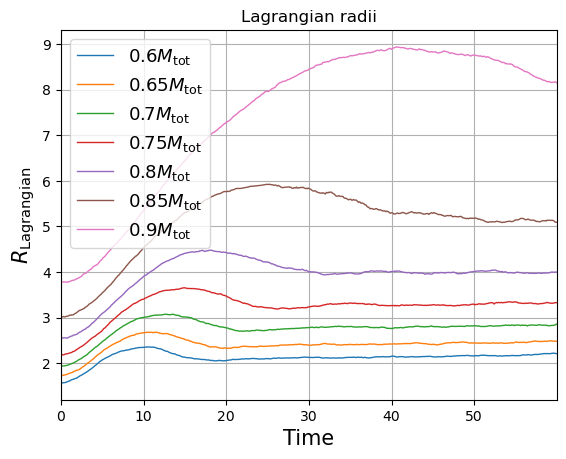

In [139]:
np.random.seed(0)

R_max = 1 # Massima distanza considerando tutte le particelle a tutti i tempi
R_min = 0 # Minima distanza
w = np.array([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]) # percentuali della massa totale che voglio analizzare
M_tot = 1 # Massa totale
N = 10000 # N paricelle
t = times # vettore dei tempi

r = np.zeros((N, len(times)))
for i in range(0,N): 
    r[i, :] = r_t[f"{i}"]

m_vect = M_tot / N * np.ones((N, 1)) # vettore colonna masse
R_lagrangian = np.zeros((len(w), len(t)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)

for i in range(len(w)):
    M = w[i] * M_tot
    dr = (R_max - R_min) / (N - 1)

    for s in range(len(t)):
        combinedMatrix = np.hstack((r[:, s].reshape(-1, 1), m_vect))
        sortedMatrix = combinedMatrix[combinedMatrix[:, 0].argsort()]
        rr = sortedMatrix[:, 0]
        mass = sortedMatrix[:, 1]

        m = 0
        last_index = 0

        while m < M:
            index = np.where(rr[last_index:] <= R_lagrangian[i, s])[0]
            
            if len(index) == 0:
                R_lagrangian[i, s] += dr
            else:
                last_index += index[-1] + 1
                m = np.sum(mass[:last_index])

                if m >= M:
                    break
                else:
                    dr = rr[last_index] - R_lagrangian[i, s]
                    R_lagrangian[i, s] += dr
    
    ax.plot(t, R_lagrangian[i], linewidth=1)

ax.set_title('Lagrangian radii')
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('$R_{\mathrm{Lagrangian}}$', fontsize=15)
ax.legend([f'${w[i]}M_{{\mathrm{{tot}}}}$' for i in range(len(w))], fontsize=13)
ax.set_xlim([t[0], t[-1]])


Here we plotted the lagrangian radii that go from 60% to 90% of the total mass.
We can notice that the muss up to the 90% of the total mass keep to be bounded to the system, and so we have a little fraction of the total mass that is ejected away.